In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from utils.kernels import get_xis
from kernels.squared_exponential import SquaredExponential
from kernels.matern import Matern
import math
import pytorch_finufft.functional as pff
# import sys
# sys.path.append('/Users/colecitrenbaum/Documents/GPs/gp-quadrature/Tests and Sanity Checks/')
from efgpnd import ToeplitzND, compute_convolution_vector_vectorized_dD, _cmplx, nufft_var_est_nd, diag_sums_nd, efgp_nd, EFGPND, efgpnd_gradient_batched
import warnings
# warnings.filterwarnings("ignore", message=".*disabling cuda.*")


In [13]:
# --- Parameters ---
n = 200_000  # Number of points
d = 2  # Dimensionality of the input space
true_length_scale = 0.5
true_variance = 1.0
true_noise_variance = 0.2
dtype = torch.float32  # Use float64 for numerical stability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Generate Input Points ---
# Generate random points in d-dimensional space from -1 to 1
# set seed
torch.manual_seed(42)
x = torch.rand(n, d, dtype=dtype, device=device) * 2 - 1

# --- Create a patchy dataset by removing various regions ---
# Define parameters for the patches
num_patches = 25  # Increased number of patches for patchier data
min_radius = 0.1  # Smaller minimum radius for more varied patches
max_radius = 0.4  # Maximum radius for patches

# Generate random centers for the patches
torch.manual_seed(123)  # For reproducibility
patch_centers = torch.rand(num_patches, d, dtype=dtype, device=device) * 2 - 1

# Generate random radii for each patch
patch_radii = torch.rand(num_patches, dtype=dtype, device=device) * (max_radius - min_radius) + min_radius

# Create a mask to identify points to keep (True = keep, False = remove)
mask = torch.ones(n, dtype=torch.bool, device=device)

# For each patch, mark points within its random radius for removal
for i, center in enumerate(patch_centers):
    # Calculate Euclidean distance from each point to the patch center
    distances = torch.sqrt(torch.sum((x - center)**2, dim=1))
    
    # Add some irregularity to the patches by using different shapes
    if i % 3 == 0:  # Circular patches
        patch_mask = distances <= patch_radii[i]
    elif i % 3 == 1:  # Elliptical patches
        # Create elongated patches in random directions
        angle = torch.rand(1, device=device) * math.pi
        x_dist = (x[:, 0] - center[0]) * torch.cos(angle) + (x[:, 1] - center[1]) * torch.sin(angle)
        y_dist = (x[:, 0] - center[0]) * -torch.sin(angle) + (x[:, 1] - center[1]) * torch.cos(angle)
        patch_mask = (x_dist/patch_radii[i])**2 + (y_dist/(patch_radii[i]*0.5))**2 <= 1
    else:  # Square-like patches
        x_dist = torch.abs(x[:, 0] - center[0])
        y_dist = torch.abs(x[:, 1] - center[1])
        patch_mask = (x_dist <= patch_radii[i]*0.8) & (y_dist <= patch_radii[i]*0.8)
    
    # Remove points in this patch
    mask = mask & (~patch_mask)

# Apply the mask to keep only points outside the patches
x = x[mask]

# Update n to reflect the new number of points
n = x.size(0)
print(f"Removed {num_patches} patches of various shapes. New dataset size: {n} points")

# --- Add some clustered points to make the data even more realistic ---
# Generate a few dense clusters
num_clusters = 8
cluster_points_per_cluster = 1000
cluster_centers = torch.rand(num_clusters, d, dtype=dtype, device=device) * 1.6 - 0.8  # Slightly inside the domain
cluster_std = 0.05  # Small standard deviation for tight clusters

# Generate and add clustered points
clustered_points = []
for center in cluster_centers:
    # Generate points in a Gaussian cluster around the center
    cluster = torch.randn(cluster_points_per_cluster, d, dtype=dtype, device=device) * cluster_std + center
    # Clip to ensure points stay in domain
    cluster = torch.clamp(cluster, -1, 1)
    clustered_points.append(cluster)

# Combine all clustered points and add to dataset
clustered_points = torch.cat(clustered_points, dim=0)
x = torch.cat([x, clustered_points], dim=0)

# Shuffle the dataset to mix regular and clustered points
indices = torch.randperm(x.size(0), device=device)
x = x[indices]

# Update n to reflect the final number of points
n = x.size(0)
print(f"Added {num_clusters} dense clusters. Final dataset size: {n} points")

# --- Define the true function ---
def true_function(x):
    """
    A 2D function to generate synthetic data
    x: tensor of shape [n, 2]
    """
    # More complex function with multiple features at different scales
    return torch.sin(3 * x[:, 0]) * torch.cos(4 * x[:, 1]) + \
           0.5 * torch.exp(-((x[:, 0] - 0.3)**2 + (x[:, 1] + 0.3)**2) / 0.3) + \
           0.7 * torch.sin(2 * math.pi * (x[:, 0]**2 + x[:, 1]**2)) + \
           0.3 * torch.cos(8 * x[:, 0]) + \
           0.2 * torch.sin(10 * x[:, 1]) * torch.exp(-((x[:, 0] + 0.5)**2) / 0.8)

# --- Generate target values with non-uniform noise ---
# Compute true function values
f_true = true_function(x)

# Add non-uniform Gaussian noise (more noise near edges, less in center)
distance_from_center = torch.sqrt(torch.sum(x**2, dim=1))
noise_scale = 0.5 + 0.5 * distance_from_center  # Noise increases with distance from center
noise = torch.randn(n, dtype=dtype, device=device) * noise_scale * math.sqrt(true_noise_variance)
y = f_true + noise


Removed 25 patches of various shapes. New dataset size: 78340 points
Added 8 dense clusters. Final dataset size: 86340 points


In [14]:
import torch
import math

def cheb_lobatto_nodes_1d(N: int, a: float, b: float, device=None, dtype=None):
    """
    Return N+1 Chebyshev–Lobatto nodes on [a,b].
    """
    k = torch.arange(0, N+1, device=device, dtype=dtype)
    x_cheb = torch.cos(math.pi * k / N)               # in [-1,1]
    # scale to [a,b]:
    return 0.5*(b - a)*x_cheb + 0.5*(b + a)

def cheb_lobatto_grid(N: int, x_min: torch.Tensor, x_max: torch.Tensor):
    """
    Build a full tensor-product grid of Chebyshev–Lobatto nodes.
    
    Inputs:
      - N       : degree per dim (so N+1 nodes in each dim)
      - x_min   : (d,) tensor of lower bounds
      - x_max   : (d,) tensor of upper bounds
    
    Returns:
      - grid    : ((N+1)^d, d) tensor of all node locations
    """
    d = x_min.numel()
    device, dtype = x_min.device, x_min.dtype
    
    # 1) build list of 1D node‐arrays
    nodes_1d = [
        cheb_lobatto_nodes_1d(N, x_min[j].item(), x_max[j].item(),
                              device=device, dtype=dtype)
        for j in range(d)
    ]
    # 2) meshgrid them (indexing='ij' to get tensor‐product)
    mesh = torch.meshgrid(*nodes_1d, indexing='ij')
    # 3) flatten into list of points
    grid = torch.stack([m.flatten() for m in mesh], dim=-1)
    return grid

# --- example usage ---
d = x.shape[1]
x_min = x.min(dim=0).values      # (d,)
x_max = x.max(dim=0).values      # (d,)
N = 23                       # polynomial degree = 10 -> 11 nodes/dim

x_new = cheb_lobatto_grid(N, x_min, x_max)
stoch_shape = 200

x_new_stoch = cheb_lobatto_grid(stoch_shape, x_min, x_max)
print(x_new.shape)
# x_new now has shape ((N+1)^d, d)





torch.Size([576, 2])


In [15]:
print('x_new.shape', x_new.shape)
print('x_new_stoch.shape', x_new_stoch.shape)

x_new.shape torch.Size([576, 2])
x_new_stoch.shape torch.Size([40401, 2])


In [16]:
d= 2 
x0 = x.min(dim=0).values  
x1 = x.max(dim=0).values  
# input_range = x1.max() - x0.min()
# lengthscale = input_range * 0.1  # 10% of the input range
# kernel = SquaredExponential(dimension=d, lengthscale=lengthscale, variance=1)
kernel = SquaredExponential(dimension=d, lengthscale=0.5, variance=1)
# kernel = Matern(dimension=d, name='matern32', lengthscale=0.5, variance=1)
# Calculate lengthscale as a fraction of the input space range
init_kernel = kernel
sigmasq = torch.tensor(0.1) # noise variance 
EPSILON = 1e-4 # bound on kernel error 

In [17]:
cg_tol = EPSILON 
model = EFGPND(
    x        = x,               
    y        = y,               
    kernel   = kernel,
    sigmasq  = sigmasq,
    eps      = EPSILON,
    opts     = {
        "cg_tolerance"     : cg_tol,
        "early_stopping"   : True,
    },
)



In [24]:
from efgpnd import Adam
max_iters = 50
J = 10
## hyper learning with Adam
model = EFGPND(x, y, kernel="SquaredExponential", eps=EPSILON)
# params = next(model.parameters())

optimizer = Adam(model.parameters(), lr=0.1)
for it in range(max_iters):
    optimizer.zero_grad()
     # saves grads in model._gp_params so that we can step 
    model.compute_gradients(
                trace_samples=J,
            )

    optimizer.step() 
    


    if it % 10 == 0:
        lengthscale = model.kernel.get_hyper('lengthscale')
        variance = model.kernel.get_hyper('variance')
        sigmasq = model._gp_params.sig2.item()
        # Get current values for printing
        print(f"[ε={EPSILON} | J={J}] iter {it:>3}  "
            f"ℓ={lengthscale:.4g}  "
            f"σ_f²={variance:.4g}  σ_n²={sigmasq:.4g}")

print(f'Final hyperparams: ℓ={lengthscale:.4g}, σ_f²={variance:.4g}, σ_n²={sigmasq:.4g}')


[ε=0.0001 | J=10] iter   0  ℓ=0.1958  σ_f²=0.7945  σ_n²=0.099
[ε=0.0001 | J=10] iter  10  ℓ=0.1829  σ_f²=0.3378  σ_n²=0.1905
[ε=0.0001 | J=10] iter  20  ℓ=0.1753  σ_f²=0.2224  σ_n²=0.1547
[ε=0.0001 | J=10] iter  30  ℓ=0.1783  σ_f²=0.2081  σ_n²=0.1418
[ε=0.0001 | J=10] iter  40  ℓ=0.1766  σ_f²=0.2314  σ_n²=0.1607
Final hyperparams: ℓ=0.1766, σ_f²=0.2314, σ_n²=0.1607


In [25]:
# Time different variance estimation methods
import time

# No variance
start_time = time.time()
mean_no_var, _ = model.predict(x_new, return_variance=False)
no_var_time = time.time() - start_time
print(f"Time without variance: {no_var_time:.4f} seconds")


Time without variance: 0.4513 seconds


In [166]:
n = 100
ground_truth_grid_size = 300
# fit with degree 4 in each dim, predict on a 50×50 grid:
deg = [4,4]
xs = np.linspace(x_new[:,0].min(), x_new[:,0].max(), ground_truth_grid_size)
ys = np.linspace(x_new[:,1].min(), x_new[:,1].max(), ground_truth_grid_size)
XX, YY = np.meshgrid(xs, ys)
pts = np.vstack([XX.ravel(), YY.ravel()]).T

In [167]:
# Generate ground truth
start_time = time.time()
mean, ground_truth_var = model.predict(torch.tensor(pts), return_variance=True, variance_method="regular")
ground_truth_time = time.time() - start_time
print(f"Time to compute ground truth variance, pts.shape = {pts.shape}: {ground_truth_time:.4f} seconds")


Time to compute ground truth variance, pts.shape = (90000, 2): 1599.4389 seconds


In [168]:
# Save data for later use
import pickle

# Create a dictionary with all the data we want to save
save_data = {
    'pts': pts,
    'ground_truth_var': ground_truth_var.cpu().numpy(),
    'x': x.cpu().numpy(),
    'y': y.cpu().numpy(),
    'model_params': {
        'lengthscale': model.kernel.lengthscale,
        'variance': model.kernel.variance,
        'sigmasq': model.sigmasq
    }
}

# Save to a file
with open('patchy_variance_shootoutdata.pkl', 'wb') as f:
    pickle.dump(save_data, f)

print(f"Saved data with {len(pts)} points and ground truth variance")


Saved data with 90000 points and ground truth variance


In [26]:
start_time = time.time()
hutchinson_probes = 600
mean, stoch_var = model.predict(torch.tensor(x_new_stoch), return_variance=True, variance_method="stochastic", hutchinson_probes=hutchinson_probes)
stoch_var_time = time.time() - start_time
print(f"Time with stochastic variance, pts.shape = {x_new_stoch.shape}, {hutchinson_probes} probes: {stoch_var_time:.4f} seconds")
# start_time = time.time()
# hutchinson_probes = 1000
# mean, stoch_var = model.predict(x_new, return_variance=True, variance_method="stochastic", hutchinson_probes=hutchinson_probes)
# stoch_var_time = time.time() - start_time
# print(f"Time with stochastic variance, x_new.shape = {x_new.shape}, {hutchinson_probes} probes: {stoch_var_time:.4f} seconds")




/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_60597/1007739140.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, stoch_var = model.predict(torch.tensor(x_new_stoch), return_variance=True, variance_method="stochastic", hutchinson_probes=hutchinson_probes)


Time with stochastic variance, pts.shape = torch.Size([40401, 2]), 600 probes: 10.1081 seconds


In [27]:
# Regular variance
start_time = time.time()
mean, var = model.predict(x_new, return_variance=True, variance_method="regular")
reg_var_time = time.time() - start_time
print(f"Time with regular variance, x_new.shape = {x_new.shape}: {reg_var_time:.4f} seconds")

Time with regular variance, x_new.shape = torch.Size([576, 2]): 8.7166 seconds


# Can we do the regular variance vaster by directly computing the diagonal entries.. 

In [209]:
from numpy.polynomial.chebyshev import chebvander
from typing import Sequence, Tuple

def cheb_interp_fit_predict(
    x_new: np.ndarray,
    var:   np.ndarray,
    x_eval: np.ndarray,
    deg:   Sequence[int]
) -> np.ndarray:
    """
    Fit a d‐dimensional Chebyshev interpolant on (x_new, var) and predict at x_eval.
    
    Parameters
    ----------
    x_new : (n, d) array of original sample locations
    var   : (n,) or (n,1) array of original values
    x_eval: (m, d) array of new points where you want predictions
    deg   : length‐d sequence, deg[j]=maximum Chebyshev degree in dimension j
    
    Returns
    -------
    var_pred : (m,) array of interpolated values at x_eval
    """
    # --- 1) basic shapes & flatten var
    x_new = x_new.cpu().numpy()
    n, d = x_new.shape
    m, d2 = x_eval.shape
    assert d == d2, "x_new and x_eval must have same number of columns"
    var = var.ravel()
    
    # --- 2) record domain for each dimension
    
    x_min = x_new.min(axis=0)
    x_max = x_new.max(axis=0)
    
    # --- 3) scale both sets to [-1,1]^d
    def scale(x):
        return 2*(x - x_min)/(x_max - x_min) - 1
    xn_s = scale(x_new)
    xe_s = scale(x_eval)
    
    # --- 4) build 1D Chebyshev‐Vandermonde for each dim
    Vs_fit = [chebvander(xn_s[:, j], deg[j]) for j in range(d)]
    Vs_eval = [chebvander(xe_s[:, j], deg[j]) for j in range(d)]
    
    # --- 5) form full tensor‐product design matrix (rowwise kronecker)
    #     start with dim 0, then fold in dims 1…d-1
    A_fit = Vs_fit[0]
    A_eval = Vs_eval[0]
    for j in range(1, d):
        A_fit  = np.einsum('ik,ij->ijk', A_fit,  Vs_fit[j]).reshape(n,  -1)
        A_eval = np.einsum('ik,ij->ijk', A_eval, Vs_eval[j]).reshape(m, -1)
    
    # --- 6) solve for Chebyshev coefficients c
    #     if you have as many equations as unknowns, this is exact interpolation
    c, *_ = np.linalg.lstsq(A_fit, var, rcond=None)
    
    # --- 7) predict
    var_pred = A_eval.dot(c)
    return var_pred

deg = [20,20]
chebyshev_var_regular = np.clip(cheb_interp_fit_predict(x_new, var, pts, deg), 0, model.kernel.variance)
chebyshev_var_stoch = np.clip(cheb_interp_fit_predict(x_new_stoch, stoch_var, pts, deg), 0, model.kernel.variance)

    


/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_37702/3324727597.py:59: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  var_pred = A_eval.dot(c)


In [173]:
chebyshev_var_stoch.shape

(90000,)

In [174]:
# # plot var versus x_new
# plt.figure(figsize=(10, 8))
# plt.scatter(x_new[:, 0], x_new[:, 1], c=var, cmap='viridis', s=50)
# plt.colorbar(label='Variance')
# plt.xlabel('x1')
# plt.ylabel('x2')
# plt.title('Variance of True Function')

In [175]:
# # plot x_new points on a 2d plot
# plt.figure(figsize=(10, 8))
# plt.scatter(x_new[:, 0], x_new[:, 1], c=var, cmap='viridis', s=50)
# plt.colorbar(label='Variance')
# plt.xlabel('x1')
# plt.ylabel('x2')
# plt.title('Regular Variance on x_new Chebyshev Grid')

Text(0.5, 1.0, 'Stochastic Variance')

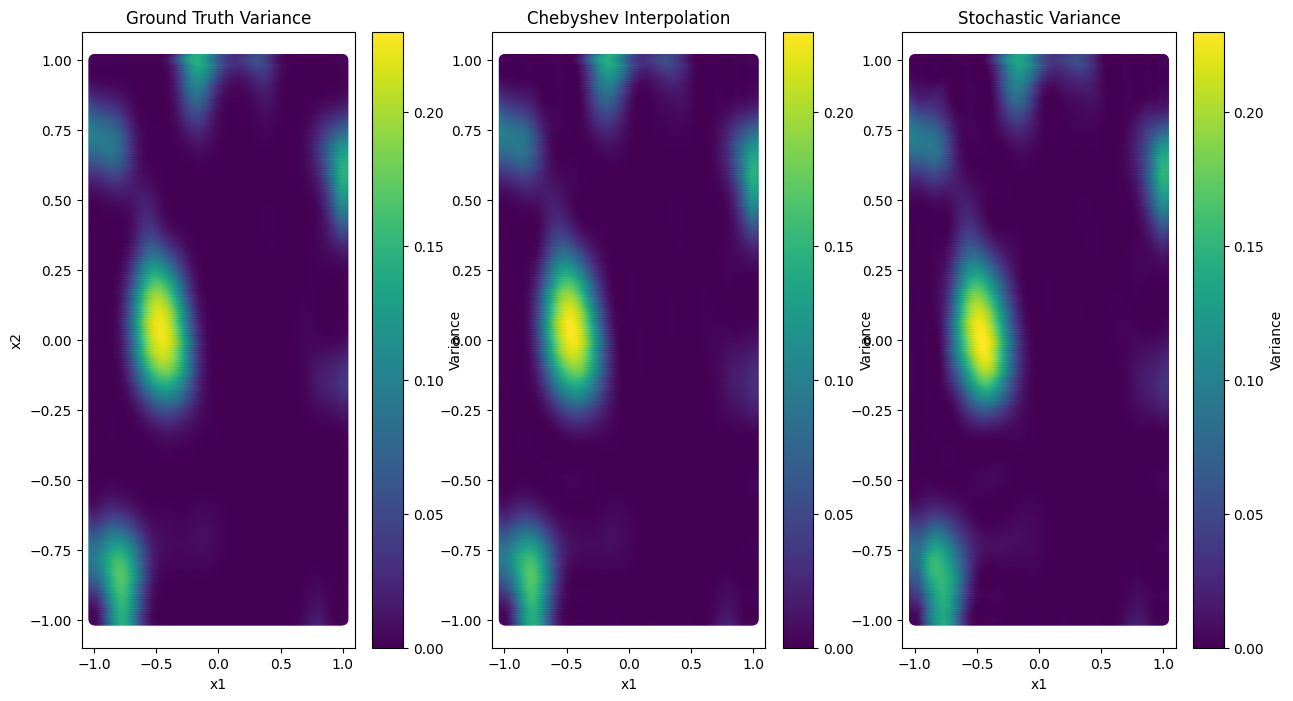

In [210]:
# plot Zpred versus pt on 2d plot in one subplot, then in the other var versus x_new in another subplot
plt.figure(figsize=(15, 8))

# Determine the min and max values for consistent color scaling
vmin = min(ground_truth_var.min(), chebyshev_var_regular.min(), stoch_var.min())
vmax = max(ground_truth_var.max(), chebyshev_var_regular.max(), stoch_var.max())

plt.subplot(1, 3, 1)
scatter1 = plt.scatter(pts[:, 0], pts[:, 1], c=ground_truth_var, cmap='viridis', s=50, vmin=vmin, vmax=vmax)
plt.colorbar(scatter1, label='Variance')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Ground Truth Variance')

# plt.subplot(1, 4, 2)
# plt.scatter(x_new[:, 0], x_new [:, 1], c=var, cmap='viridis', s=50)
# plt.colorbar(label='Variance')
# plt.xlabel('x1')
# plt.title('Regular Variance Grid Points')
plt.subplot(1, 3, 2)
scatter2 = plt.scatter(pts[:, 0], pts[:, 1], c=chebyshev_var_regular, cmap='viridis', s=50, vmin=vmin, vmax=vmax)
plt.colorbar(scatter2, label='Variance')
plt.xlabel('x1')
plt.title('Chebyshev Interpolation')

plt.subplot(1, 3, 3)
scatter3 = plt.scatter(pts[:, 0], pts[:, 1], c=chebyshev_var_stoch, cmap='viridis', s=50, vmin=vmin, vmax=vmax)
plt.colorbar(scatter3, label='Variance')
plt.xlabel('x1')
plt.title('Stochastic Variance')


/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_37702/4161858213.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  chebyshev_mse = torch.mean((ground_truth_var - chebyshev_var_regular)**2).item()
/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_37702/4161858213.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  stochastic_mse = torch.mean((ground_truth_var - chebyshev_var_stoch)**2).item()


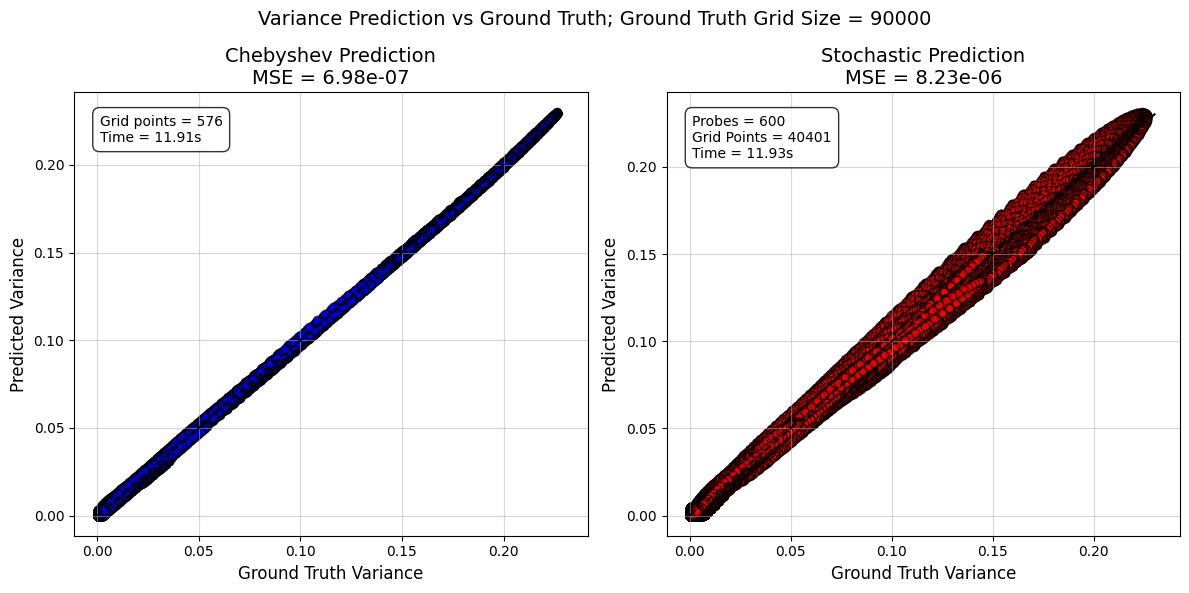

In [211]:
# Create a figure with two subplots for comparison plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Calculate Mean Squared Error for each method
chebyshev_mse = torch.mean((ground_truth_var - chebyshev_var_regular)**2).item()
stochastic_mse = torch.mean((ground_truth_var - chebyshev_var_stoch)**2).item()

# First subplot: Chebyshev comparison
ax1.scatter(ground_truth_var, chebyshev_var_regular, alpha=0.7, c='blue', edgecolors='k')
# Add y=x line
min_val = min(ground_truth_var.min(), chebyshev_var_regular.min())
max_val = max(ground_truth_var.max(), chebyshev_var_regular.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'k--')
ax1.set_xlabel('Ground Truth Variance', fontsize=12)
ax1.set_ylabel('Predicted Variance', fontsize=12)
ax1.set_title(f'Chebyshev Prediction\nMSE = {chebyshev_mse:.2e}', fontsize=14)
ax1.grid(True, alpha=0.5)
ax1.annotate(f'Grid points = {x_new.shape[0]}\nTime = {reg_var_time:.2f}s', 
             xy=(0.05, 0.95), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8),
             va='top')

# Second subplot: Stochastic comparison
ax2.scatter(ground_truth_var, chebyshev_var_stoch, alpha=0.7, c='red', edgecolors='k')
# Add y=x line
min_val = min(ground_truth_var.min(), chebyshev_var_stoch.min())
max_val = max(ground_truth_var.max(), chebyshev_var_stoch.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'k--')
ax2.set_xlabel('Ground Truth Variance', fontsize=12)
ax2.set_ylabel('Predicted Variance', fontsize=12)
ax2.set_title(f'Stochastic Prediction\nMSE = {stochastic_mse:.2e}', fontsize=14)
ax2.grid(True, alpha=0.5)
ax2.annotate(f'Probes = {hutchinson_probes}\nGrid Points = {x_new_stoch.shape[0]}\nTime = {stoch_var_time:.2f}s', 
             xy=(0.05, 0.95), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8),
             va='top')

plt.suptitle(f'Variance Prediction vs Ground Truth; Ground Truth Grid Size = {pts.shape[0]}', fontsize=14)
plt.tight_layout()


In [179]:
# # MSE as function of grid size, hutchinson probes
# probes =
# num_grids = 5
# regular_grid_sizes = torch.linspace(10, 100, num_grids)
# stochastic_grid_sizes = torch.linspace(50, 300, num_grids)
# hutchinson_probes = 500
# mse_regular = []
# mse_stochastic = []
# time_regular = []
# time_stochastic = []
# for grid_size in range(num_grids):
#     # for probes in hutchinson_probes:
#         x_new_regular = cheb_lobatto_grid(regular_grid_sizes[grid_size], x_min, x_max)
#         x_new_stochastic = cheb_lobatto_grid(stochastic_grid_sizes[grid_size], x_min, x_max)
#         # time the regular variance
#         start_time = time.time()
#         mean, var = model.predict(x_new_regular, return_variance=True, variance_method="regular")
#         reg_var_time = time.time() - start_time
#         interpolated_var = cheb_interp_fit_predict(x_new_regular, var, pts, [15,15])
#         mse_regular.append(torch.mean((ground_truth_var - interpolated_var)**2).item())
#         time_regular.append(reg_var_time)
#         # time the stochastic variance
#         start_time = time.time()
#         mean, stoch_var = model.predict(x_new_stochastic, return_variance=True, variance_method="stochastic", hutchinson_probes=probes)
#         stoch_var_time = time.time() - start_time
#         time_stochastic.append(stoch_var_time)

#         interpolated_var = cheb_interp_fit_predict(x_new_stochastic, stoch_var, pts, [15,15])
#         mse_stochastic.append(torch.mean((ground_truth_var - interpolated_var)**2).item())

SyntaxError: invalid syntax (4028939913.py, line 2)

In [47]:
regular_grid_sizes.shape

torch.Size([10])

ValueError: x and y must have same first dimension, but have shapes (10,) and (19,)

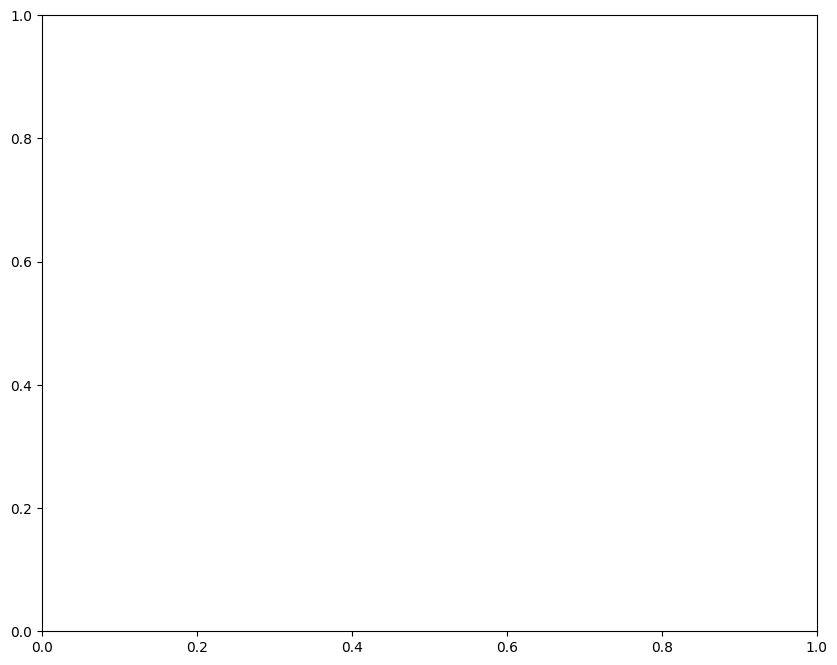

In [44]:
# plot mse as function of grid size and hutchinson probes
plt.figure(figsize=(10, 8))
plt.plot(regular_grid_sizes, mse_regular, label='Regular Variance')
plt.plot(stochastic_grid_sizes, mse_stochastic, label='Stochastic Variance')
plt.xlabel('Grid Size')
plt.ylabel('MSE')
plt.legend()